In [1]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [2]:
%matplotlib inline

In [3]:
import networkx as nx

In [13]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in#fly = flylist[4]
#fly.open_signals() flylist]

In [75]:
flydict = {}
for fly in flylist:
    flydict[fly.flynum] = fly

In [124]:
sorted_keys = sorted(fly.spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]
#state_mtrx = np.vstack([fly.spikestates[key] for key in sorted_keys])

In [320]:
stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0'),
                  ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=8, b_y=0')]

#stim_conditions = [('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0')]
state_mtrx_dict = {}
for fly in flylist:
    state_mtrx_dict[fly.flynum] = {}
    idxs = list()
    for stim_condition in stim_conditions:
        idxs.extend(fly.block_data[stim_condition])
    for muscle_key in sorted_keys:
        state_mtrx_dict[fly.flynum][muscle_key] = [(fly.spikestates[muscle_key][idx],idx) for idx in idxs]

In [321]:
def get_transitions(state_mtrx_dict,muscle_key,pre_trig_idx = 10,post_trig_idx = 100):
    off_on_list = []
    on_off_list = []
    for flynum,tdict in state_mtrx_dict.items():
        for row in tdict[muscle_key]:
            off_on_idx = np.argwhere(np.diff(row[0]) == 1)
            on_off_idx = np.argwhere(np.diff(row[0]) == -1)
            
            for idx in off_on_idx:
                if (idx+post_trig_idx < len(row[0])) & (idx-pre_trig_idx > 0):
                    off_on_list.append((flynum,row[1][idx-pre_trig_idx:idx+post_trig_idx]))
            for idx in on_off_idx:
                if (idx+post_trig_idx < len(row[0])) & (idx-pre_trig_idx > 0):
                    on_off_list.append((flynum,row[1][idx-pre_trig_idx:idx+post_trig_idx]))
    return {'off_on':off_on_list,'on_off':on_off_list}            

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


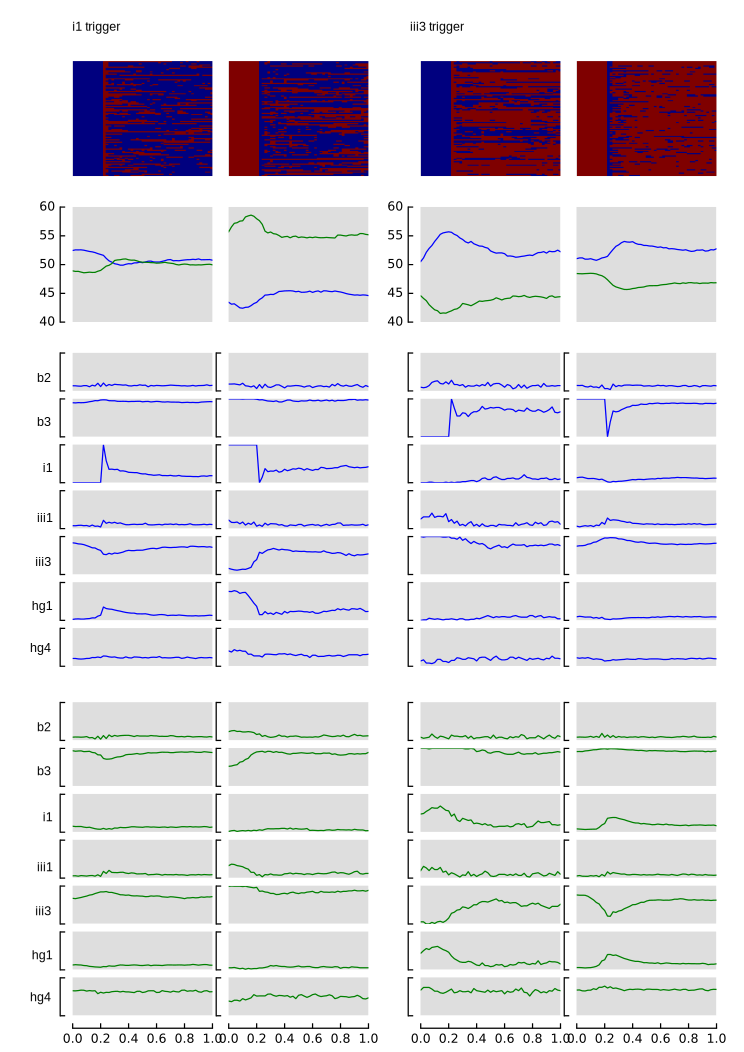

In [322]:
def plot_trig_panel(ax_group,
                    trig_key,
                    direction = 'off_on',
                    ts = 0.02,
                    pretrig = 10,
                    posttrig = 50):
    time = np.arange(pretrig+posttrig)*ts
    idx_list = get_transitions(state_mtrx_dict,trig_key,pretrig,posttrig)
    signal_mtrxs = {}
    for key in sorted_keys:
        signal_mtrxs[key] = np.vstack([flydict[fnum].spikestates[key][idx] for fnum,idx in idx_list[direction]])
    signal_mtrxs['left','amp'] =  np.hstack([np.array(flydict[fnum].left_amp)[idx] for fnum,idx in idx_list[direction]]).T
    signal_mtrxs['right','amp'] =  np.hstack([np.array(flydict[fnum].right_amp)[idx] for fnum,idx in idx_list[direction]]).T
    filter_cond = np.sum(signal_mtrxs[trig_key][:,:11],axis = 1) == {'off_on':0,'on_off':1*11}[direction]
    rast_mtrx = signal_mtrxs[trig_key][filter_cond,:]
    rast_mtrx = rast_mtrx[np.random.randint(0,rast_mtrx.shape[0],size = 100),:]
    ax_group['raster'].imshow(rast_mtrx,
               aspect = 'auto',interpolation = 'nearest',extent = [0,time[-1],0,100])
    ax_group['raster'].set_ybound(0,100)
    ax_group['kine'].plot(time,np.rad2deg(np.nanmean(signal_mtrxs['left','amp'][filter_cond,:],axis = 0)))
    ax_group['kine'].plot(time,np.rad2deg(np.nanmean(signal_mtrxs['right','amp'][filter_cond,:],axis = 0)))
    for key,ax in ax_group['left'].items():
        ax.plot(time,np.nanmean(signal_mtrxs['left',key][filter_cond,:],axis = 0),color = 'b')
    for key,ax in ax_group['right'].items():
        ax.plot(time,np.nanmean(signal_mtrxs['right',key][filter_cond,:],axis = 0),color = 'g')


layout = fifi.FigureLayout('reconvolution_layout.svg',make_mplfigures=True)

ts = 0.02
pretrig = 10 #samples
posttrig = 50 #samples

ax_group = layout.axes_groups['none']['i1_on']
plot_trig_panel(ax_group,('left','i1'),direction = 'off_on',ts = ts,pretrig = pretrig,posttrig = posttrig)
ax_group = layout.axes_groups['none']['i1_off']
plot_trig_panel(ax_group,('left','i1'),direction = 'on_off',ts = ts,pretrig = pretrig,posttrig = posttrig)

ax_group = layout.axes_groups['none']['iii3_on']
plot_trig_panel(ax_group,('left','b3'),direction = 'off_on',ts = ts,pretrig = pretrig,posttrig = posttrig)
ax_group = layout.axes_groups['none']['iii3_off']
plot_trig_panel(ax_group,('left','b3'),direction = 'on_off',ts = ts,pretrig = pretrig,posttrig = posttrig)

for ax in layout.axes.values():
    ax.set_xbound(0,1)
    
layout.apply_mpl_methods()
fifi.mpl_functions.set_spines(layout)
layout.save('reconvolution.svg')
plt.close('all')
display(SVG('reconvolution.svg'))